## ECE495 Lab2: Krichmar Path Planning using Nengo

This Lab uses Nengo to find the optimal path of a square or rectangular map using Krichmar's spike-wave propagation algorithm. The objectives of this lab are to:
- Implement Krichmar's spike-wave propagation algorithm using Nengo neurons
- Ensure the spike wave works for any rectangular or square map
- Utilize an "off-chip" AER to compute the fastest route to get from any starting point (location) to any ending point (location)

_Note: This is your assignment description and a proposed outline by which you can complete your assignment_
- The assignment is worth 60 points
- You may hardcode your connections for each of the three required maps _for a max score of 50/60_
- _**Be sure to print your final path for each map or save it somewhere in your repository so that I can check your work!**_

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [133]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2
from nengo.dists import Uniform

### Input Maps

Check that your spike-wave propagation and AER work for these three maps:
 
(a) The following $3 \times 3$ array with start location 0 (top left) and end location 8 (bottom right). 
$$\begin{bmatrix} 1 & 2 & 1 \\
                  1 & 3 & 5 \\
                  7 & 1 & 1
                      \end{bmatrix}$$

(b) The following $3 \times 4$ array with start location 0 and end location 11.
$$\begin{bmatrix} 1 & 2 & 1 & 6 \\
                  1 & 3 & 5 & 3 \\
                  7 & 1 & 4 & 1
                      \end{bmatrix}$$

(c) The following $5 \times 5$ array with start location 10 and end location 4.
$$\begin{bmatrix} 1 & 3 & 7 & 2 & 1\\
                  3 & 1 & 5 & 3 & 1\\
                  3 & 2 & 6 & 1 & 2\\
                  3 & 1 & 5 & 6 & 1\\
                  2 & 2 & 1 & 1 & 2
                      \end{bmatrix}$$


In [134]:
#write my array 


map_1 = np.array([
    [1, 2, 1],
    [1, 3, 5],
    [7, 1, 1]
])

map_2 = np.array([
    [1, 2, 1, 6],
    [1, 3, 5, 3],
    [7, 1, 4, 1]
])

map_3 = np.array([
    [1, 3, 7, 2, 1],
    [3, 1, 5, 3, 1],
    [3, 2, 6, 1, 2],
    [3, 1, 5, 6, 1],
    [2, 2, 1, 1, 2]
])


#this is where I select differnt maps
my_array = map_1


#my_dimensions = np.shape(my_array) #this should give me the dimenstions. 

size_of_array = (my_array.size)


#finds how many in each row and columb.
num_rows,num_cols = my_array.shape

# print(num_rows)
# print(num_cols)
# print(size_of_array)


### Set up and run your Nengo model to implement the spike-wave propagation
_Be sure to generalize or take the 10 points deduction!_

Hints: 
- Use a piecewise function to kick off the spike wave, then turn off your input and let the wave do the rest. Be sure this input connects to your _start location._
- Use a Nengo Ensemble for each map location (you can use an Ensemble array, a multidimensional ensemble, or a list of ensembles). Every map location has anywhere from 3 (corner locations) to 8 (inside locations) neighbors to which it can send a spike. Be careful with your connections! I personally said each of them had 8 possible locations and then deleted any locations that were "off-map", but do what makes the most sense to you. 
- Create a delay node to emulate an axonal delay from Krichmar's algorithm. Each map location should have a delay equal to the weight (difficulty of traversal) of the location.
- Implementing inhibition is _difficult_! Recall from Krichmar's algorithm that once a map location fires, it should not fire again. If you can't get the inhibition to work, instead try to add another function to your delay node that turns off a map location once it's sent the spike wave forward

In [135]:
class Inhibit:
    def __init__(self, dimensions):
        self.spike_started = False
        self.spike_ended = False

    def inhibit(self, t, x):
        if not self.spike_started and x > 0.1:
            self.spike_started = True
        
        if self.spike_started and x < 0.1:
            self.spike_ended = True
        
        if not self.spike_ended:
            return x
        else:
            return 0
        
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        return self.history[0]


model = nengo.Network(label="Lab2 map", seed=123)
with model:

#node just passes value though 
#ensable is a bunch neruonrs. 
    # list of ensambles so should be the same dimensions as 'size_of_array'
    neurons = np.empty((num_rows, num_cols), dtype=object)

    # Fill the matrix with inhibition neurons
    n_neurons_map = 100
    for row in range(neurons.shape[0]):
        for col in range(neurons.shape[1]):
            map_ensemble = nengo.Ensemble(n_neurons=n_neurons_map, dimensions=1)
            inhibit = Inhibit()
            inhibit_node = nengo.Node(inhibit.inhibit, size_in = 1, size_out = 1)
            nengo.Connection(map_ensemble, inhibit_node)
            neurons[row, col] = (map_ensemble, inhibit_node)
        

#CONNECTING TO OTHERS

#split map into sections: edge, corner, center
        
    connect = np.empty((num_rows, num_cols), dtype=object)
    # Fill the matrix with empty lists
    for row in range(connect.shape[0]):
        for col in range(connect.shape[1]):
            connect[row, col] = []

    for i in range(num_rows):
        for j in range(num_cols):


            #EDGES X4

            #Edge TOP
            if (i==0) and (0 < j < num_cols-1):
                
                connect[i, j].append([i, j+1])
                connect[i, j].append([i, j-1])
                connect[i, j].append([i+1, j+1])
                connect[i, j].append([i+1, j])
                connect[i, j].append([i+1, j-1])
            #Edge BOTTOM
            elif (i==num_rows-1) and (0 < j < num_cols-1):
                connect[i,j].append([i, j+1])
                connect[i,j].append([i, j-1])
                connect[i,j].append([i-1, j+1])
                connect[i,j].append([i-1, j])
                connect[i,j].append([i-1, j-1])
            #Edge LEFT
            elif (0 < i < num_rows-1) and (j==0):
                connect[i,j].append([i-1, j])
                connect[i,j].append([i-1, j+1])
                connect[i,j].append([i, j+1])
                connect[i,j].append([i+1, j+1])
                connect[i,j].append([i+1, j])
            #Edge RIGHT
            elif (0 < i < num_rows-1) and (j==num_cols-1):
                connect[i,j].append([i-1, j])
                connect[i,j].append([i-1, j-1])
                connect[i,j].append([i, j-1])
                connect[i,j].append([i+1, j-1])
                connect[i,j].append([i+1, j])

            #CORNERS X4
                
            #Corner TOP LEFT
            elif (i==0) and (j==0):
                connect[i,j].append([i, j+1])
                connect[i,j].append([i+1, j+1])
                connect[i,j].append([i+1, j])
            #Corner TOP RIGHT
            elif (i==0) and (j==num_cols-1):
                connect[i,j].append([i, j-1])
                connect[i,j].append([i+1, j-1])
                connect[i,j].append([i+1, j])
            #Corner BOTTOM LEFT
            elif (i==num_rows-1) and (j==0):
                connect[i,j].append([i-1, j])
                connect[i,j].append([i-1, j+1])
                connect[i,j].append([i, j+1])
            #Corner BOTTOM RIGHT
            elif (i==num_rows-1) and (j==num_cols-1):
                connect[i,j].append([i, j-1])
                connect[i,j].append([i-1, j-1])
                connect[i,j].append([i-1, j])

            #CENTER -- rest of them
                
            #Center Case
            else:
                connect[i,j].append([i-1, j])
                connect[i,j].append([i-1, j+1])
                connect[i,j].append([i, j+1])
                connect[i,j].append([i+1, j+1])
                connect[i,j].append([i+1, j])
                connect[i,j].append([i+1, j-1])
                connect[i,j].append([i, j-1])
                connect[i,j].append([i-1, j-1])


print(connect)
print(connect[0, 0])
print(len(connect[0, 0]))

my_neighbors = connect[0, 0]
for neighbor in my_neighbors:
    print(neighbor[0])
    print(neighbor[1])

print(connect[0, 0][0])

# print(connect[1:1])
# print(connect[2:2])





### Create AER off-neuron
_Pay attention to how Krichmar says he uses the AER to determine the path_  

Hints:
- The AER contains a location and a time of first spike.
- Start at the end location and work backward!
- I found that by looking at the first spike times of all possible neighboring map locations and choosing the smallest time allowed me to work from end node to start node for my optimal path.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:03.                                                 
This is time step where the pulse first begins:  256
This time step occurs at approximately  0.256  seconds


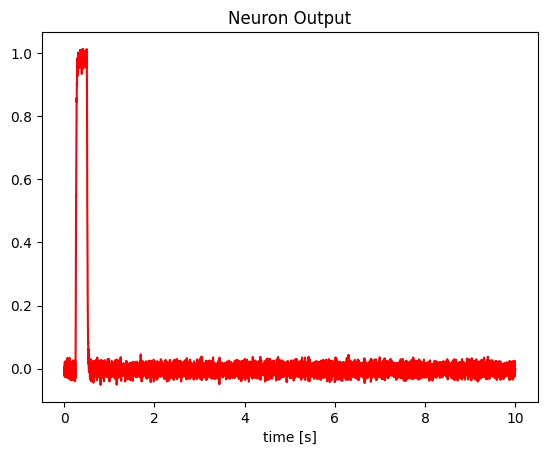

In [136]:
with model:

    inp_node = nengo.Node(Piecewise({0: 0, .25: 1, .5: 0})) # quick spike into start node
    start_location = (0, 0)
    inp_neuron = neurons[start_location[0], start_location[1]][0]

    nengo.Connection(inp_node,inp_neuron)

    neuron_probe = nengo.Probe(inp_neuron, synapse=0.01)

# Build the simulator to run the model containing just input encoding
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(10)

# Plot the decoded input from the neuron
plt.figure()
plt.plot(sim.trange(), sim.data[neuron_probe], "r")
plt.xlabel("time [s]")
plt.title("Neuron Output")



# note that sim.data[neuron_probe] is an Nx1 array, 
#  which means there's a second dimension we don't care about.
#  The spike data occurs in dimension 0. Grab that one.
aer = sim.data[neuron_probe][:,0]>.25
spikes_locs = np.where(aer == True)
first_spike = np.min(spikes_locs)

print("This is time step where the pulse first begins: ", first_spike)

dt = .001 # default nengo timestep
print("This time step occurs at approximately ", first_spike*dt, " seconds")

### Print your optimal path
_Be sure to show your results_  

Some options:
- You can print your map locations as x- and y- coordinates (examples: start_loc = [0,0] or [2,0]) or flattened locations (examples: start_loc = 0 or 10)
- You can create a picture of a map (like in Krichmar's paper) where you draw out your final path

In [137]:
aer_matrix = np.zeros((num_rows, num_cols))
for row in range(num_rows):
    for col in range(num_cols):
        inhibit_object = neurons[row, col][2]
        spike_time = inhibit_object.time_spike_ended
        aer_matrix[row, col] = spike_time 

print(aer_matrix)




AttributeError: 'Inhibit' object has no attribute 'time_spike_ended'